In [27]:
import numpy as np
import time
import matplotlib.pyplot as plt
from scipy.linalg import qr

In [28]:
# 生成距离矩阵
def distance_matrix(Theta):
    diff = Theta[:, np.newaxis, :] - Theta[np.newaxis, :, :]
    D = np.sum(diff**2, axis=2)
    return D

# 生成矩阵M
def compute_matrix_M(alpha, Theta):
    n, r = Theta.shape
    ones_n = np.ones((n, 1))

    # 计算 1_n * alpha^T 和 alpha * 1_n^T
    term1 = np.dot(ones_n, alpha.reshape(1, -1))
    term2 = np.dot(alpha.reshape(-1, 1), ones_n.T)
    
    # 计算距离矩阵 D 使用向量化方法
    D =  distance_matrix(Theta)

    # 计算最终的矩阵 M
    M = term1 + term2 - D
    return M

# 生成邻接矩阵
def generate_adj(alpha, Theta, scale):
    # 计算 m 矩阵
    M = compute_matrix_M(alpha, Theta)

    # # 生成邻接矩阵
    adjacency_matrix = np.random.normal(loc=M, scale=scale)

    # # 由于邻接矩阵应该是对称的，我们取上三角和下三角的最大值
    adjacency_matrix = np.triu(adjacency_matrix, 1) + np.triu(adjacency_matrix, 1).T
    return adjacency_matrix

# 计算释然函数
def f(A, alphas, thetas, scale):
    M = compute_matrix_M(alphas, thetas)
    result = np.sum((A*M - 0.5*M**2)/scale - A**2/(2*scale) - 0.5*np.log(2*np.pi*scale))
    diagonal_correction = np.sum(np.diag((A*M - 0.5*M**2)/scale - A**2/(2*scale) - 0.5*np.log(2*np.pi*scale)))
    
    return result-diagonal_correction

# 投影函数
def Projection(X,C):
    return X if np.linalg.norm(X) < C else C*X/np.linalg.norm(X)

# 对theta梯度
def gradient_theta(A, alphas, thetas, sacle):
    # 使用已定义的函数计算 M 矩阵
    M = compute_matrix_M(alphas, thetas)
    
    # 计算每个节点对的 theta 差值
    np.fill_diagonal(M, 0)
    diff = thetas[:, np.newaxis, :] - thetas[np.newaxis, :, :]  # (num_nodes, num_nodes, num_theta_dims)
    
    # 计算梯度贡献项
    term = (-2 * (diff * A[:, :, np.newaxis]) + 2 * diff * M[:, :, np.newaxis])/sacle
    
    # 求和所有贡献以更新梯度
    gradient = np.sum(term, axis=1)
    
    return gradient

# 对alpha梯度
def gradient_alpha(A, alphas, thetas, scale):
    # 使用之前定义的 compute_matrix_M 函数计算 M
    M = compute_matrix_M(alphas, thetas)
    
    # 注意我们需要移除对角线上的元素，因为 i 不等于 j
    np.fill_diagonal(M, 0)
    
    # 每个 alpha[i] 的梯度由所有 j!=i 的 sigmoid_M[i, j] 贡献
    gradient = np.sum((A - M)/scale, axis=1)
    
    return gradient


def generate_theta(n, r):
    Theta_prime = np.random.randn(n, r)
    
    Theta_centered = Theta_prime - np.mean(Theta_prime, axis=0)
    
    Q, R = qr(Theta_centered)
    
    norms = np.linalg.norm(Q, axis=0)
    Theta = Q / norms
    
    return Theta


def main(num_samples, k, C, initial_learning_rate, tolerance, scale):
    # Generate true parameters
    true_alpha = np.random.rand(num_samples)
    true_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples, -1)

    adjacency_matrix = generate_adj(true_alpha, true_theta, scale)
    distance_matrix_true = distance_matrix(true_theta)
    pred_alpha = np.random.rand(num_samples)
    pred_theta = np.random.uniform(-45*np.pi/161, 45*np.pi/161, num_samples*k).reshape(num_samples, -1)

    # Initial log likelihood
    logli = f(adjacency_matrix, pred_alpha, pred_theta, scale)
    prev_logli = logli  # Initialize previous log likelihood

    # Training loop
    flag = True
    iter = 0
    learning_rate = initial_learning_rate  # Initialize learning rate
    
    # list
    logli_list = []
    avg_loss_theta, avg_loss_alpha = [], []
    max_loss_theta, max_loss_alpha = [], []
    while flag:
        # Update theta
        grad_y = gradient_theta(adjacency_matrix, pred_alpha, pred_theta, scale)
        temp_theta = Projection(pred_theta + learning_rate * grad_y, C)

        # Update alpha
        grad_x = gradient_alpha(adjacency_matrix, pred_alpha, temp_theta, scale)
        temp_alpha = Projection(pred_alpha + learning_rate * grad_x, C)

        # Calculate new log likelihood
        temp_logli = f(adjacency_matrix, temp_alpha, temp_theta, scale)
        
        # Check improvement in log likelihood
        if temp_logli - prev_logli < 0:
            # If log likelihood decreases, reduce learning rate without updating parameters
            learning_rate /= 5
        else:
            # If log likelihood improves, update parameters and reset learning rate
            iter += 1
            pred_theta = temp_theta
            pred_alpha = temp_alpha
            logli = temp_logli

            
            diff_distance = distance_matrix_true - distance_matrix(pred_theta)
            diff_alpha = true_alpha - pred_alpha
            avg_loss_theta.append(np.linalg.norm(diff_distance, 'fro') ** 2 / num_samples ** 2)
            avg_loss_alpha.append(np.linalg.norm(diff_alpha) ** 2 / num_samples)
            max_loss_theta.append(np.abs(diff_distance).max())
            max_loss_alpha.append(np.abs(diff_alpha).max())
            logli_list.append(logli)

            # Check for convergence
            if logli - prev_logli > 0 and (logli - prev_logli)/np.abs(prev_logli) < tolerance:
                flag = False
            # Reset learning rate for the next iteration
            prev_logli = logli
            learning_rate = initial_learning_rate
 
    return  avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta, logli_list, (true_alpha, true_theta, pred_alpha, pred_alpha)

#### 测试
+ 邻接矩阵考虑为如下adjacency_matrix
+ 初始的$\alpha$和$\theta$为如下的alpha和theta变量

In [ ]:
alpha = np.array([0,1,2])
theta = np.array([[0,0],[1,1],[2,2]])
adjacency_matrix = np.array([[0,2,3],[2,0,4],[3,4,0]])
distance_matrix_true = distance_matrix(true_theta)

In [ ]:
# 验证对theta梯度是否正确(正确)
gradient_theta(adjacency_matrix, alpha, theta)

In [ ]:
# 验证对alpha梯度是否正确(正确)
gradient_alpha(adjacency_matrix, true_alpha, true_theta)

#### 梯度下降测试

In [ ]:
np.random.seed(2)
scale = 1
num_samples =  600
k = 2 
C = 10000
learning_rate  = 0.01/num_samples
tolerace = 0.00001

avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta, logli_list, para_ = main(num_samples, k, C, learning_rate, tolerace, scale)

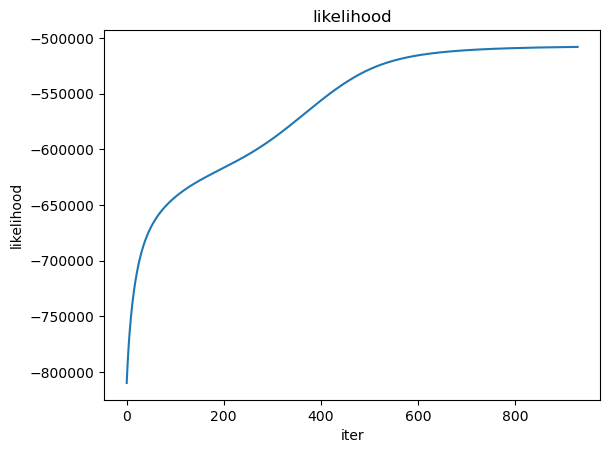

In [30]:
plt.plot(logli_list[1:])
plt.title(fr'likelihood')
plt.xlabel('iter')
plt.ylabel('likelihood')
plt.show()

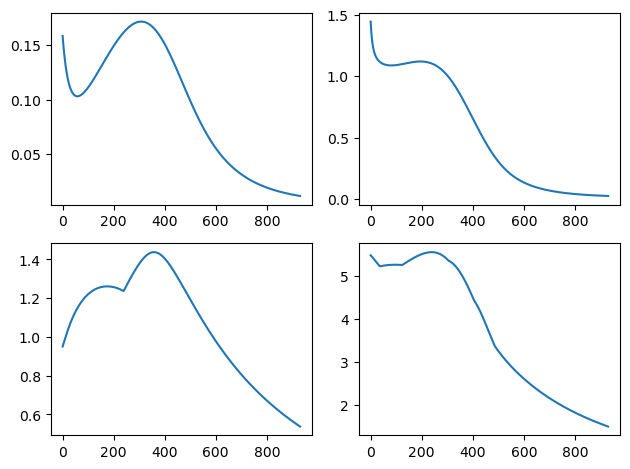

In [31]:
# 四大误差图
avg_loss_alpha, avg_loss_theta, max_loss_alpha, max_loss_theta

fig, axs = plt.subplots(2, 2)

axs[0, 0].plot(avg_loss_alpha)
axs[0, 1].plot(avg_loss_theta)
axs[1, 0].plot(max_loss_alpha)
axs[1, 1].plot(max_loss_theta)

plt.tight_layout()

plt.show()